PART 1:

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {device}")



model_id = "HuggingFaceTB/SmolLM2-135M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

model.eval()


rm_id = "OpenAssistant/reward-model-deberta-v3-large-v2"
rm_tokenizer = AutoTokenizer.from_pretrained(rm_id)
rm_model = AutoModelForSequenceClassification.from_pretrained(rm_id).to(device)
rm_model.eval()

print("Models loaded successfully.")

Running on device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Models loaded successfully.


Strategies

In [ ]:
def get_next_token_logits(input_ids, model):

    with torch.no_grad():
        outputs = model(input_ids)
    return outputs.logits[:, -1, :]


def greedy_search(model, tokenizer, prompt_ids, max_new_tokens=50):
    generated = prompt_ids
    for _ in range(max_new_tokens):
        logits = get_next_token_logits(generated, model)
        next_token = torch.argmax(logits, dim=-1).unsqueeze(0)

        generated = torch.cat([generated, next_token], dim=1)
        if next_token.item() == tokenizer.eos_token_id:
            break
    return generated


def beam_search(model, tokenizer, prompt_ids, beam_width=3, max_new_tokens=50):
    beams = [(0.0, prompt_ids)]

    for _ in range(max_new_tokens):
        candidates = []
        all_beams_finished = True

        for score, seq in beams:
            if seq[0, -1].item() == tokenizer.eos_token_id:
                candidates.append((score, seq))
                continue

            all_beams_finished = False
            logits = get_next_token_logits(seq, model)
            probs = F.log_softmax(logits, dim=-1)

            top_scores, top_indices = torch.topk(probs, k=beam_width * 2, dim=-1)

            for i in range(top_scores.shape[1]):
                token_score = top_scores[0, i].item()
                token_id = top_indices[0, i].unsqueeze(0).unsqueeze(0)
                new_seq = torch.cat([seq, token_id], dim=1)
                new_score = score + token_score
                candidates.append((new_score, new_seq))

        if all_beams_finished:
            break

        ordered = sorted(candidates, key=lambda x: x[0], reverse=True)
        beams = ordered[:beam_width]

    return beams[0][1]
def top_k_sampling(model, tokenizer, prompt_ids, k=50, temperature=1.0, max_new_tokens=50):
    generated = prompt_ids
    for _ in range(max_new_tokens):
        logits = get_next_token_logits(generated, model)

        logits = logits / temperature
        top_k_logits, top_k_indices = torch.topk(logits, k)
        probs = F.softmax(top_k_logits, dim=-1)
        next_token_idx = torch.multinomial(probs, num_samples=1)
        next_token = top_k_indices.gather(-1, next_token_idx)

        generated = torch.cat([generated, next_token], dim=1)
        if next_token.item() == tokenizer.eos_token_id:
            break
    return generated

def top_p_sampling(model, tokenizer, prompt_ids, p=0.9, temperature=1.0, max_new_tokens=50):
    generated = prompt_ids
    for _ in range(max_new_tokens):
        logits = get_next_token_logits(generated, model)

        logits = logits / temperature
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        sorted_probs = F.softmax(sorted_logits, dim=-1)

        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

        sorted_indices_to_remove = cumulative_probs > p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = float('-inf')

        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        generated = torch.cat([generated, next_token], dim=1)
        if next_token.item() == tokenizer.eos_token_id:
            break
    return generated

Metric functions

In [ ]:
def calculate_distinct_n(texts, n):

    unique_ngrams = set()
    total_ngrams = 0

    for text in texts:
        tokens = text.split()
        if len(tokens) < n:
            continue

        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        unique_ngrams.update(ngrams)
        total_ngrams += len(ngrams)

    if total_ngrams == 0: return 0.0
    return len(unique_ngrams) / total_ngrams

def get_reward_score(prompt_text, generated_text):

    input_text = f"Question: {prompt_text}\nAnswer: {generated_text}"

    inputs = rm_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        score = rm_model(**inputs).logits[0].cpu().item()
    return score

Setup

Starting Decoding Analysis...


Prompts: 100%|██████████| 5/5 [03:17<00:00, 39.43s/it]



Analysis Complete. Generating Plots...


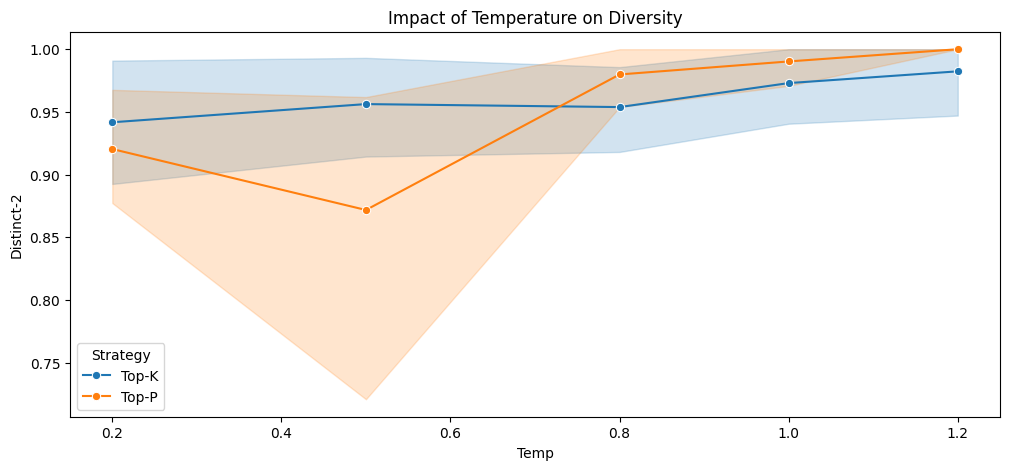

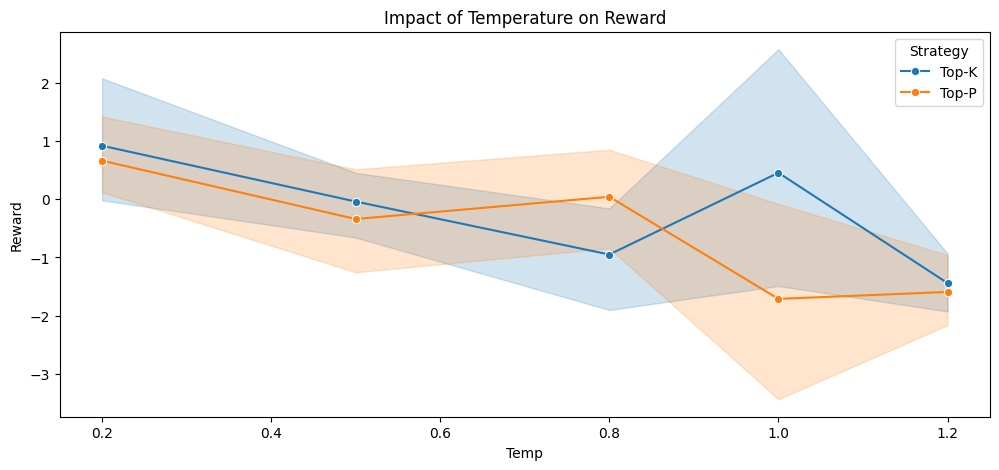


=== SUMMARY STATS (Check Lengths Here!) ===
                 Reward  Distinct-2  Length
Strategy Temp                              
Beam     0.0   0.016788    0.783793    36.8
Greedy   0.0   0.250607    0.912046    37.4
Top-K    0.2   0.916636    0.941701    38.8
         0.5  -0.040352    0.956213    36.0
         0.8  -0.948965    0.953828    39.0
         1.0   0.453028    0.972973    38.0
         1.2  -1.438374    0.982353    36.0
Top-P    0.2   0.660315    0.920341    39.2
         0.5  -0.339890    0.871705    41.4
         0.8   0.040869    0.979853    40.2
         1.0  -1.709532    0.990244    36.2
         1.2  -1.591005    1.000000    38.0

[PASS]: Greedy Search avg length is 37.4 words. Diversity scores are likely valid.


In [9]:

prompts = [
    "Explain gravity to a 5-year-old.",
    "Write a short poem about a robot.",
    "List three healthy breakfast ideas.",
    "How do I change a tire on a car?",
    "Why is the sky blue?"
]

results = []
print("Starting Decoding Analysis...")


temperatures = [0.2, 0.5, 0.8, 1.0, 1.2]

for prompt in tqdm(prompts, desc="Prompts"):
    g_out = generate_text("greedy", prompt)
    results.append({
        "Strategy": "Greedy", "Temp": 0.0, "Prompt": prompt,
        "Reward": get_reward_score(prompt, g_out),
        "Distinct-2": calculate_distinct_n([g_out], 2),
        "Length": len(g_out.split())
    })


    b_out = generate_text("beam", prompt, beam_width=3)
    results.append({
        "Strategy": "Beam", "Temp": 0.0, "Prompt": prompt,
        "Reward": get_reward_score(prompt, b_out),
        "Distinct-2": calculate_distinct_n([b_out], 2),
        "Length": len(b_out.split())
    })


    for t in temperatures:

        k_out = generate_text("top_k", prompt, k=50, temperature=t)
        results.append({
            "Strategy": "Top-K", "Temp": t, "Prompt": prompt,
            "Reward": get_reward_score(prompt, k_out),
            "Distinct-2": calculate_distinct_n([k_out], 2),
            "Length": len(k_out.split())
        })

        # Top-P
        p_out = generate_text("top_p", prompt, p=0.9, temperature=t)
        results.append({
            "Strategy": "Top-P", "Temp": t, "Prompt": prompt,
            "Reward": get_reward_score(prompt, p_out),
            "Distinct-2": calculate_distinct_n([p_out], 2),
            "Length": len(p_out.split())
        })

df_temp = pd.DataFrame(results)


print("\nAnalysis Complete. Generating Plots...")


plt.figure(figsize=(12, 5))
sns.lineplot(data=df_temp[df_temp["Temp"]>0], x="Temp", y="Distinct-2", hue="Strategy", marker="o")
plt.title("Impact of Temperature on Diversity")
plt.show()
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_temp[df_temp["Temp"]>0], x="Temp", y="Reward", hue="Strategy", marker="o")
plt.title("Impact of Temperature on Reward")
plt.show()

summary = df_temp.groupby(["Strategy", "Temp"])[["Reward", "Distinct-2", "Length"]].mean()
print(summary)

greedy_len = summary.loc[("Greedy", 0.0), "Length"]
if greedy_len < 20:
    print(f"\n[CRITICAL WARNING]: Greedy Search avg length is only {greedy_len:.1f} words.")
    print("High diversity scores are likely fake due to short outputs.")
else:
    print(f"\n[PASS]: Greedy Search avg length is {greedy_len:.1f} words. Diversity scores are likely valid.")